# GAN-Flowers

In [34]:
# mount google drive for saving generated images and model checkpoints
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## install requirements

In [ ]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

## Setup

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import os
import PIL.Image
import tensorflow_datasets as tfds
import pathlib
import glob
import imageio
import time
from IPython import display

## Load and prepare the dataset

We will use the tf_flower dataset to train the generator and the discriminator. The generator will generate flower images resembling the tf_flower data.

In [36]:
# download dataset
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [37]:
# number of samples
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


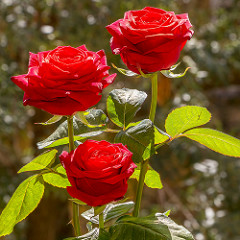

In [38]:
# show some flower images
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

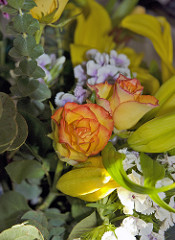

In [39]:
PIL.Image.open(str(roses[1]))

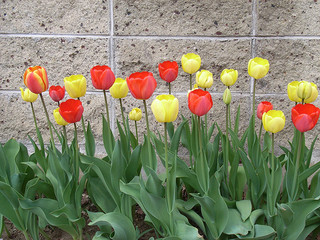

In [40]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

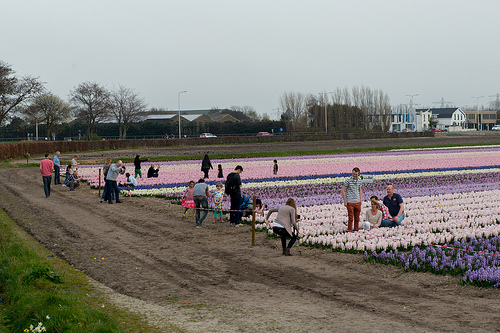

In [41]:
PIL.Image.open(str(tulips[1]))

In [42]:
# set hyperparameter
batch_size = 128
img_height = 64
img_width = 64

In [43]:
# creating tensorflow dataset, batching and resizing
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  labels=None,
  validation_split=0.001,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 1 classes.
Using 3667 files for training.


In [44]:
train_ds

<BatchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

In [45]:
# show a batch of dataset
for image_batch in train_ds:
  print(image_batch.shape)
  break

(128, 64, 64, 3)


In [47]:
# data augmentation layers
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal")
])

normalization_layer = layers.Rescaling(scale=1./127.5, offset=-1) # Normalize the images to [-1, 1]

In [48]:
# augment, normalize and shuffle the dataset
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(lambda x: normalization_layer(x), num_parallel_calls=AUTOTUNE)

train_ds = train_ds.shuffle(1000)

train_ds = train_ds.map(lambda x: data_augmentation(x, training=True), num_parallel_calls=AUTOTUNE)

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)


# check being normalized a batch of dataset
image_batch = next(iter(train_ds))
first_image = image_batch[0]

# Notice the pixel values are now in `[-1,1]`.
print(np.min(first_image), np.max(first_image))

-1.0 0.99931073


In [49]:
train_ds

<PrefetchDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>

## Create the models

Both the generator and discriminator are defined using the Keras Sequential API.

### Generator model

The generator uses tf.keras.layers.Conv2DTranspose (upsampling) layers to produce an image from a seed (random noise). Start with a Dense layer that takes this seed as input, then upsample several times until you reach the desired image size of 64x64x3. Notice the tf.keras.layers.ReLU activation for each layer, except the output layer which uses tanh.

In [50]:
  # Generator model
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(4*4*512, use_bias=False, input_shape=(100,)))
    model.add(layers.Reshape((4, 4, 512)))

    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

Use the (as yet untrained) generator to create an image.

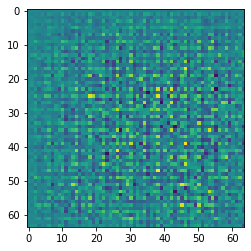

In [51]:
# show a generated image from a random vector (noise)
generator = make_generator_model()
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 1])

In [52]:
# check the shape of a generated image
generated_image.shape

TensorShape([1, 64, 64, 3])

### Discriminator model

The discriminator is a CNN-based image classifier.

In [53]:
# Discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential()

    model.add(layers.Dropout(0.5, input_shape=[64, 64, 3]))

    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))           
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(1, (4, 4), padding='same', activation='sigmoid'))

    # model.add(layers.Flatten())
    # model.add(layers.Dense(1, activation='sigmoid'))

    return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake.

In [54]:
# show a generated image from a random vector (noise)
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor(
[[[[0.50007296]
   [0.5000593 ]
   [0.50011957]
   [0.50011486]]

  [[0.5000468 ]
   [0.5000691 ]
   [0.5001481 ]
   [0.5000775 ]]

  [[0.50001425]
   [0.5000132 ]
   [0.50007194]
   [0.4999702 ]]

  [[0.50000316]
   [0.5000066 ]
   [0.499974  ]
   [0.49995947]]]], shape=(1, 4, 4, 1), dtype=float32)


## Define the loss and optimizers

Define loss functions and optimizers for both models.

In [55]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of ones, and the discriminator's predictions on fake (generated) images to an array of zeros.

In [56]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss

The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of ones.

In [57]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since you will train two networks separately.

In [58]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

### Save checkpoints

This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [59]:
checkpoint_dir = '/content/drive/MyDrive/gan_flower_128/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop

In [60]:
BATCH_SIZE = 128
EPOCHS = 500
noise_dim = 100
num_examples_to_generate = 25

# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [61]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [62]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 50 epochs
    if (epoch + 1) % 50 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

## Generate and save images

In [63]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(5, 5))

  for i in range(predictions.shape[0]):
      plt.subplot(5, 5, i+1)
      plt.imshow((predictions[i] + 1) / 2)
      plt.axis('off')

  plt.savefig('/content/drive/MyDrive/gan_flower_128/image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()


## Train the model

Call the train() method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 500 epochs, they resemble flower images. **This may take about 1hour 42minutes with the GPU on Colab.**

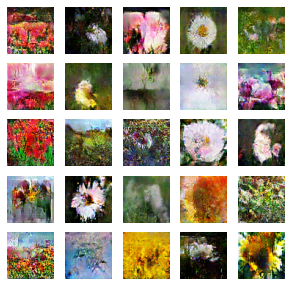

In [ ]:
train(train_ds, EPOCHS)

Restore the latest checkpoint.

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('/content/drive/MyDrive/gan_flower_128/image_at_epoch_{:04d}.png'.format(epoch_no))

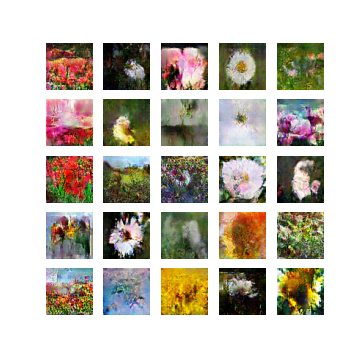

In [ ]:
display_image(EPOCHS)

Use imageio to create an animated gif using the images saved during training.



In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('/content/drive/MyDrive/gan_flower_anime/Copy of image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


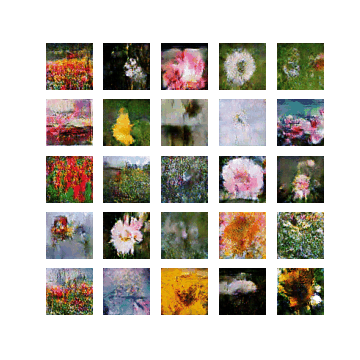

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)